## About the CIFAR-10 dataset

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (classification of small images across 10 distinct classes---airplane, automobile, bird, cat, deer, dog, frog, horse, ship & truck).


![](cifar_10.png)

The CIFAR-10 dataset contains 50000 training examples and 10000 test examples. Each example is a $32 \times 32 \times 32$ pixels coloured image.

## Loading and pre-processing CIFAR-10 dataset



Using TensorFlow backend.


(50000, 32, 32, 3)
(10000, 32, 32, 3)


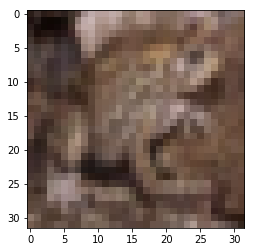

frog


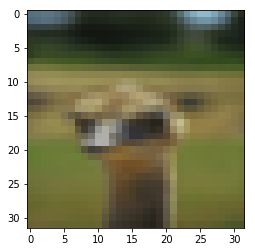

bird


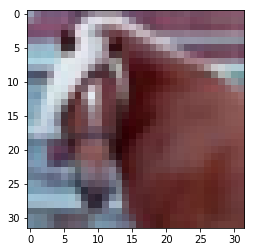

horse
(50000, 3072)
(10000, 3072)
[[ 0.34509805  0.43137255  0.48627451 ...,  0.29411766  0.33333334
   0.16470589]
 [ 0.60000002  0.61960787  0.7019608  ...,  0.41960785  0.22745098
   0.21568628]
 [ 0.11764706  0.20784314  0.02745098 ...,  0.70980394  0.57647061
   0.60000002]
 [ 0.89803922  0.89803922  0.89803922 ...,  0.88627452  0.88627452
   0.88627452]]


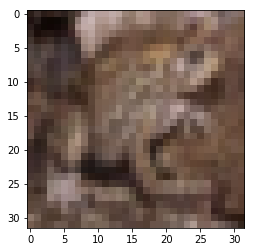

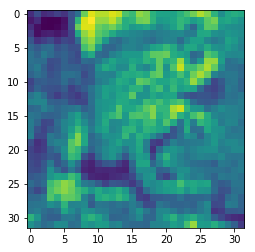

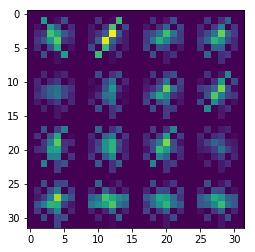

In [3]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import itertools
import os
os.environ['KERAS_BACKEND']="tensorflow"

from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from sklearn.utils import shuffle
from skimage import feature
from skimage import data

(X_train_img, y_train), (X_test_img, y_test) = cifar10.load_data() # fetch CIFAR-10 data # dirname="."??
print(X_train_img.shape)
print(X_test_img.shape)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Shuffle examples
X_train_img, y_train = shuffle(X_train_img, y_train)
X_test_img, y_test = shuffle(X_test_img, y_test)

plt.figure()
plt.imshow(X_train_img[0])
plt.show()
print(class_names[int(y_train[0])])
plt.figure()
plt.imshow(X_train_img[1])
plt.show()
print(class_names[int(y_train[1])])
plt.figure()
plt.imshow(X_train_img[2])
plt.show()
print(class_names[int(y_train[2])])

num_train, depth, height, width = X_train_img.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test_img.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

# Produce a [0;1] normalized "image" for potential input into a convNet
X_train_img_norm = X_train_img.astype('float32') 
X_test_img_norm = X_test_img.astype('float32')
X_train_img_norm /= np.max(X_train_img_norm) # Normalise data to [0, 1] range
X_test_img_norm /= np.max(X_test_img_norm) # Normalise data to [0, 1] range

# Rasterize normalized images into 1D vectors for potential input of raw image into standard ML algo such as kNN, MLP, SVM, etc
X_train_vectNorm = X_train_img_norm.reshape(num_train,height*width*depth)
X_test_vectNorm = X_test_img_norm.reshape(num_test,height*width*depth)

print(X_train_vectNorm.shape)
print(X_test_vectNorm.shape)
print(X_train_vectNorm[1:5])

######################################################
# Compute HOG feature as potential BETTER input into standard ML algo such as kNN, MLP, SVM, etc
from skimage import color

# test sur la 1ère image :
image0 = X_train_img[0]
image0_luminance = color.rgb2gray(image0) ## Il faut supprimer une dimension : on utilise la luminance plutôt que le RGB
plt.figure()
plt.imshow(image0)
plt.show()
plt.figure()
plt.imshow(image0_luminance)
plt.show()
hog0, hog_image0 = feature.hog(color.rgb2gray(image0_luminance), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
plt.figure()
plt.imshow(hog_image0)
plt.show()

# transformation des images en descripteurs HOG :
XHog_train_img = []
for img in X_train_img :
    hog, hog_image = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
    XHog_train_img.append(hog)
XHog_test_img = []
for img in X_test_img :
    hog, hog_image = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
    XHog_test_img.append(hog)

# Normalisation :
XHog_train_img_norm = np.array(XHog_train_img).astype('float32')
XHog_test_img_norm = np.array(XHog_test_img).astype('float32')
XHog_train_img_norm /= np.max(XHog_train_img_norm) # Normalise data to [0, 1] range
XHog_test_img_norm /= np.max(XHog_test_img_norm) # Normalise data to [0, 1] range


# Une fonction pour afficher graphiquement les matrices de confusion

## Baseline method: kNN on raw normalized pixels

In [4]:
#%matplotlib inline
import matplotlib.pyplot as plt
import itertools

# Definition for the function that plot the confusion matrix
# See : http://www.sci-kit.org/
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

clf = neighbors.KNeighborsClassifier(n_neighbors=5)
print(y_train.shape)
clf.fit(X_train_vectNorm[:30000], y_train.ravel()[:30000]) # utiliser toutes les données conduit à une Memory Error

y_test_pred_knn = clf.predict(X_test_vectNorm)


cnf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)
print(cnf_matrix_knn)

np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_knn, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

(50000, 1)


### Remarques sur les résultats :

La matrice de confusion est très mauvaise : toutes les images sont vues comme appartenant à la première classe. Comparer les pixels des images n'est pas une méthode très pertinente pour classifier les images. Par ailleurs, l'algorithme des plus proches voisins est très lent à s'exécuter, et utilise beaucoup de mémoire : nous avons dû limiter la taille du jeu d'entraînement pour ne pas avoir d'erreur de mémoire. En raison de ce temps d'exécution, nous n'avons testé qu'une valeur du nombre de voisins : 5.

## Random Forests on raw normalized pixels

n_estimators= 10  max_depth= None max_features= auto
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (on test set) =  0.0992
             precision    recall  f1-score   support

      plane       0.06      0.01      0.01      1000
        car       0.00      0.00      0.00      1000
       bird       0.10      0.98      0.18      1000
        cat       0.18      0.00      0.01      1000
       deer       0.00      0.00      0.00      1000
        dog       0.00      0.00      0.00      1000
       frog       0.00      0.00      0.00      1000
      horse       0.00      0.00      0.00      1000
       ship  

/home/lmeyrat/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.97  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]]


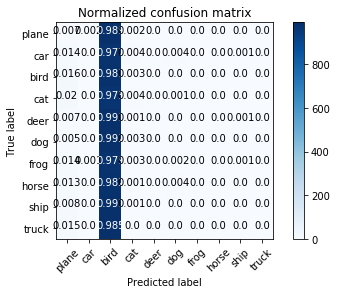

In [9]:
#Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(X_train_vectNorm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(X_test_vectNorm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(X_test_vectNorm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## Random forests on HOG descriptors

('n_estimators=', 10, ' max_depth=', None, 'max_features=', 'auto')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('Accuracy (on test set) = ', 0.34539999999999998)
             precision    recall  f1-score   support

      plane       0.39      0.50      0.44      1000
        car       0.43      0.47      0.45      1000
       bird       0.23      0.29      0.26      1000
        cat       0.18      0.19      0.18      1000
       deer       0.31      0.44      0.37      1000
        dog       0.30      0.24      0.27      1000
       frog       0.41      0.39      0.40      1000
      horse       0.39      0.27 

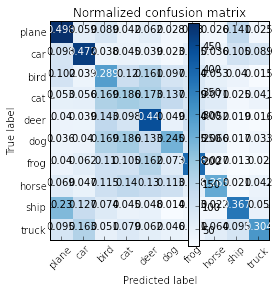

In [8]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(XHog_train_img_norm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(XHog_test_img_norm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(XHog_test_img_norm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# MLP classifier on raw Pixels

## Training

In [38]:
import os
os.environ['KERAS_BACKEND']="tensorflow"
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(42, input_dim=32*32*3))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_vectNorm, Y_train, epochs=20, batch_size=32)




Epoch 1/20
50000/50000 [==============================] - 4s - loss: 1.9312 - acc: 0.3066     
Epoch 2/20
50000/50000 [==============================] - 4s - loss: 1.7695 - acc: 0.3724     
Epoch 3/20
50000/50000 [==============================] - 4s - loss: 1.7118 - acc: 0.3927     
Epoch 4/20
50000/50000 [==============================] - 4s - loss: 1.6703 - acc: 0.4069     
Epoch 5/20
50000/50000 [==============================] - 4s - loss: 1.6361 - acc: 0.4193     
Epoch 6/20
50000/50000 [==============================] - 5s - loss: 1.6168 - acc: 0.4250     
Epoch 7/20
50000/50000 [==============================] - 4s - loss: 1.5933 - acc: 0.4333     
Epoch 8/20
50000/50000 [==============================] - 4s - loss: 1.5776 - acc: 0.4382     
Epoch 9/20
50000/50000 [==============================] - 4s - loss: 1.5643 - acc: 0.4425     
Epoch 10/20
50000/50000 [==============================] - 4s - loss: 1.5503 - acc: 0.4486     
Epoch 11/20
50000/50000 [========================

### display confusion matrix MLP

[[490  28  48  33  27  53  19  57 227  18]
 [ 59 536   9  31  11  36  19  40 155 104]
 [106  18 247  67 118 190  93 110  42   9]
 [ 29  26  51 293  37 309 104  72  52  27]
 [ 62  12  96  70 325 123 123 132  49   8]
 [ 20  26  60 166  48 450  63 105  46  16]
 [ 13  10  64 142 104 113 472  47  27   8]
 [ 49  23  30  61  58 139  17 560  34  29]
 [102  47   4  25  13  42   9  15 715  28]
 [ 75 191   7  50   7  41  25  64 164 376]]
Normalized confusion matrix
[[ 0.49  0.03  0.05  0.03  0.03  0.05  0.02  0.06  0.23  0.02]
 [ 0.06  0.54  0.01  0.03  0.01  0.04  0.02  0.04  0.15  0.1 ]
 [ 0.11  0.02  0.25  0.07  0.12  0.19  0.09  0.11  0.04  0.01]
 [ 0.03  0.03  0.05  0.29  0.04  0.31  0.1   0.07  0.05  0.03]
 [ 0.06  0.01  0.1   0.07  0.33  0.12  0.12  0.13  0.05  0.01]
 [ 0.02  0.03  0.06  0.17  0.05  0.45  0.06  0.1   0.05  0.02]
 [ 0.01  0.01  0.06  0.14  0.1   0.11  0.47  0.05  0.03  0.01]
 [ 0.05  0.02  0.03  0.06  0.06  0.14  0.02  0.56  0.03  0.03]
 [ 0.1   0.05  0.    0.03  0.01  0.04

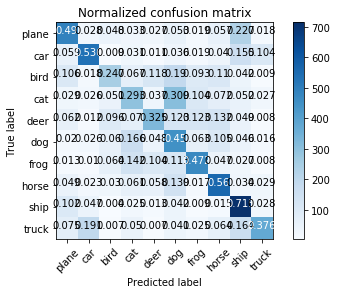

In [40]:
from sklearn.metrics import confusion_matrix

y_test_pred_mlp = model.predict(X_test_vectNorm)
Y_test_pred_mlp = np.argmax(y_test_pred_mlp, 1)

cnf_matrix_mlp = confusion_matrix(y_test, Y_test_pred_mlp)
print(cnf_matrix_mlp)
np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_mlp, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Test on single examples

(1, 3072)


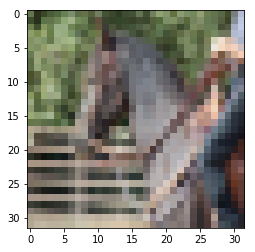

[[  9.30e-06   7.57e-06   7.10e-05   3.87e-04   3.55e-05   4.18e-04
    2.84e-05   1.22e-05   4.76e-06   6.57e-06]]
Prediction :  dog
Verité :  horse


In [45]:
def test_exemple(n):
    test = np.array([X_test_vectNorm[n]])
    print(test.shape)
    predict = model.predict_on_batch(test)
    plt.figure()
    plt.imshow(X_test_img[n])
    plt.show()
    print(predict)
    print("Prediction : ", class_names[np.argmax(predict)])
    print("Verité : ", class_names[int(y_test[n])])
    
test_exemple(27)
    

### Remarques sur les résultats du MLP
Malgrès la simplicité de l'architecture choisie, l'accuracy de ce MLP atteint presque 50%. Sont score le plus haut est sur les bateux, ce qui peut s'expliquer par la présence d'eau et de ciel sur l'image, faciles à reconnaître (d'ailleurs, 20% des avions, qui ont du ciel, sont confondus avec les bateux)
La classe la moins bien détectée est le chat, qui est souvent confondue avec les chiens, ce qui n'est pas étonnant, vue la basse résolution des images et les ressemblances entre ces animaux

# MLP classifier on HOG

## Training

In [44]:
import os
os.environ['KERAS_BACKEND']="tensorflow"
from keras.models import Sequential
from keras.layers import Dense, Activation

modelH = Sequential()
modelH.add(Dense(128, input_dim=324))
modelH.add(Activation('sigmoid'))
modelH.add(Dense(64))
modelH.add(Activation('sigmoid'))
modelH.add(Dense(10))
modelH.add(Activation('sigmoid'))

modelH.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelH.fit(XHog_train_img_norm, Y_train, epochs=100, batch_size=32)


Epoch 1/100
50000/50000 [==============================] - 2s - loss: 2.0333 - acc: 0.2416     
Epoch 2/100
50000/50000 [==============================] - 2s - loss: 1.7161 - acc: 0.3852     
Epoch 3/100
50000/50000 [==============================] - 2s - loss: 1.5966 - acc: 0.4335     
Epoch 4/100
50000/50000 [==============================] - 2s - loss: 1.5456 - acc: 0.4551     
Epoch 5/100
50000/50000 [==============================] - 2s - loss: 1.5138 - acc: 0.4678     
Epoch 6/100
50000/50000 [==============================] - 2s - loss: 1.4927 - acc: 0.4784     
Epoch 7/100
50000/50000 [==============================] - 2s - loss: 1.4743 - acc: 0.4842     
Epoch 8/100
50000/50000 [==============================] - 2s - loss: 1.4599 - acc: 0.4904     
Epoch 9/100
50000/50000 [==============================] - 2s - loss: 1.4470 - acc: 0.4931     
Epoch 10/100
50000/50000 [==============================] - 2s - loss: 1.4350 - acc: 0.4988     
Epoch 11/100
50000/50000 [=============

50000/50000 [==============================] - 2s - loss: 1.0851 - acc: 0.6200     
Epoch 86/100
50000/50000 [==============================] - 2s - loss: 1.0822 - acc: 0.6206     
Epoch 87/100
50000/50000 [==============================] - 2s - loss: 1.0788 - acc: 0.6236     
Epoch 88/100
50000/50000 [==============================] - 2s - loss: 1.0765 - acc: 0.6239     
Epoch 89/100
50000/50000 [==============================] - 2s - loss: 1.0740 - acc: 0.6251     
Epoch 90/100
50000/50000 [==============================] - 2s - loss: 1.0704 - acc: 0.6264     
Epoch 91/100
50000/50000 [==============================] - 2s - loss: 1.0676 - acc: 0.6275     
Epoch 92/100
50000/50000 [==============================] - 2s - loss: 1.0663 - acc: 0.6281     
Epoch 93/100
50000/50000 [==============================] - 2s - loss: 1.0619 - acc: 0.6288     
Epoch 94/100
50000/50000 [==============================] - 2s - loss: 1.0607 - acc: 0.6321     
Epoch 95/100
50000/50000 [=================

### display confusion matrix MLP

[[638  30  84  34  68   9  21  21  74  21]
 [ 28 721   2  28  19   7  38  13  40 104]
 [ 68   7 451  91 164  73  90  32  16   8]
 [ 28  21  72 400 165 118 110  47   5  34]
 [ 24   8  63  87 663  29  52  48  11  15]
 [ 11   5  66 185 115 413  92  85   8  20]
 [ 13  16  44  60  92  36 712  14   9   4]
 [ 15   8  27  65 108  80  23 637   5  32]
 [148  90  27  25  31   7  15  18 574  65]
 [ 32  83   5  31  30  15  12  37  38 717]]
Normalized confusion matrix
[[ 0.64  0.03  0.08  0.03  0.07  0.01  0.02  0.02  0.07  0.02]
 [ 0.03  0.72  0.    0.03  0.02  0.01  0.04  0.01  0.04  0.1 ]
 [ 0.07  0.01  0.45  0.09  0.16  0.07  0.09  0.03  0.02  0.01]
 [ 0.03  0.02  0.07  0.4   0.17  0.12  0.11  0.05  0.01  0.03]
 [ 0.02  0.01  0.06  0.09  0.66  0.03  0.05  0.05  0.01  0.01]
 [ 0.01  0.01  0.07  0.18  0.12  0.41  0.09  0.09  0.01  0.02]
 [ 0.01  0.02  0.04  0.06  0.09  0.04  0.71  0.01  0.01  0.  ]
 [ 0.01  0.01  0.03  0.07  0.11  0.08  0.02  0.64  0.01  0.03]
 [ 0.15  0.09  0.03  0.03  0.03  0.01

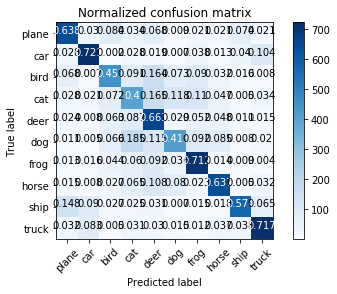

In [46]:
from sklearn.metrics import confusion_matrix

y_test_pred_mlp = modelH.predict(XHog_test_img_norm)
Y_test_pred_mlp = np.argmax(y_test_pred_mlp, 1)

cnf_matrix_mlp = confusion_matrix(y_test, Y_test_pred_mlp)
print(cnf_matrix_mlp)
np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_mlp, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Test on single examples

(1, 324)


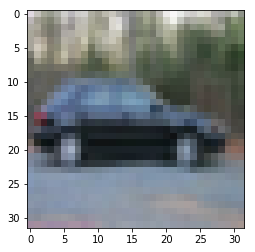

[[  1.90e-16   2.93e-14   8.55e-17   3.66e-16   3.54e-16   1.15e-16
    9.17e-17   2.59e-16   8.11e-15   3.07e-15]]
Prediction :  car
Verité :  car


In [48]:
def test_exemple_HOG(n):
    test = np.array([XHog_test_img_norm[n]])
    print(test.shape)
    predict = modelH.predict_on_batch(test)
    plt.figure()
    plt.imshow(X_test_img[n])
    plt.show()
    print(predict)
    print("Prediction : ", class_names[np.argmax(predict)])
    print("Verité : ", class_names[int(y_test[n])])
    
test_exemple_HOG(28)
    

### Comparaison MLP sur image brut et sur le HOG
Les images HOG sont significativement plus petites que les images brutes, ce qui rend l'entrainement bien plus court (pour la même archtecture, on passe à moins de 1s par epoch). Cela nous permet de faire une architecture plus complexe, avec 2 couches cachées, qui au prix d'un entrainement plus long arrice à une précision de 60% (contre < 50% sur image brute). 
Cependant, la dernière version stable de skimage ne permet de calculer le HOG que sur un seul canal : on gagne donc en reconnaissance de motifs, mais on perd les indications de couleur, qui permettait de distinguer assez efficacement les groupes (avions/bateaux) ( animaux) (vehicules terrestres) dans le MLP sur l'image brute.
Les classes les mieux détectées sont souvent les camions, bateaux et voitures, en général à 70%
La classe la moins bien détectée reste le chat, probablement pour les mêmes raisons. 
